In [87]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10, 10]

import warnings
warnings.filterwarnings("ignore")

In [39]:
#set the seed
seed = 42

## import data
[Ames Housing dataset](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt). 
Info [link](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

In [40]:
df = pd.read_csv("data/ames.csv").drop("id_parcela", axis=1) 

In [4]:
df.head()

,tipo_construccion,tipo_zona,perimetro_conectado_calle,area_parcela,tipo_acceso,tipo_acceso_trasero,forma_parcela,LandContour,tipo_instalaciones,config_parcela,...,area_piscina,calidad_piscina,calidad_valla,atributo_miscelaneo,valor_atributo_miscelaneo,mes_venta,ano_venta,tipo_venta,condicion_venta,precio_venta
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [41]:
df.shape

(2930, 80)

In [42]:
df.sample(1).T

,2601
tipo_construccion,70
tipo_zona,RL
perimetro_conectado_calle,60.0
area_parcela,7200
tipo_acceso,Pave
...,...
mes_venta,4
ano_venta,2006
tipo_venta,WD
condicion_venta,Normal


In [43]:
df.precio_venta.describe()

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: precio_venta, dtype: float64

In [44]:
df[["precio_venta"]].describe()

,precio_venta
count,2930.000000
mean,180796.060068
std,79886.692357
min,12789.000000
25%,129500.000000
50%,160000.000000
75%,213500.000000
max,755000.000000


## Tratamiento por tipo de datos

In [45]:
df.dtypes

tipo_construccion              int64
tipo_zona                     object
perimetro_conectado_calle    float64
area_parcela                   int64
tipo_acceso                   object
                              ...   
mes_venta                      int64
ano_venta                      int64
tipo_venta                    object
condicion_venta               object
precio_venta                   int64
Length: 80, dtype: object

In [46]:
df["ano_construccion_garaje"] = df["ano_construccion_garaje"].astype('object')

## Tratamiento Inicial de Datos Nulos

En esta primera parte se observan los datos nulos, buscando eliminar los que contaminan el set inicial de datos

<Axes: >

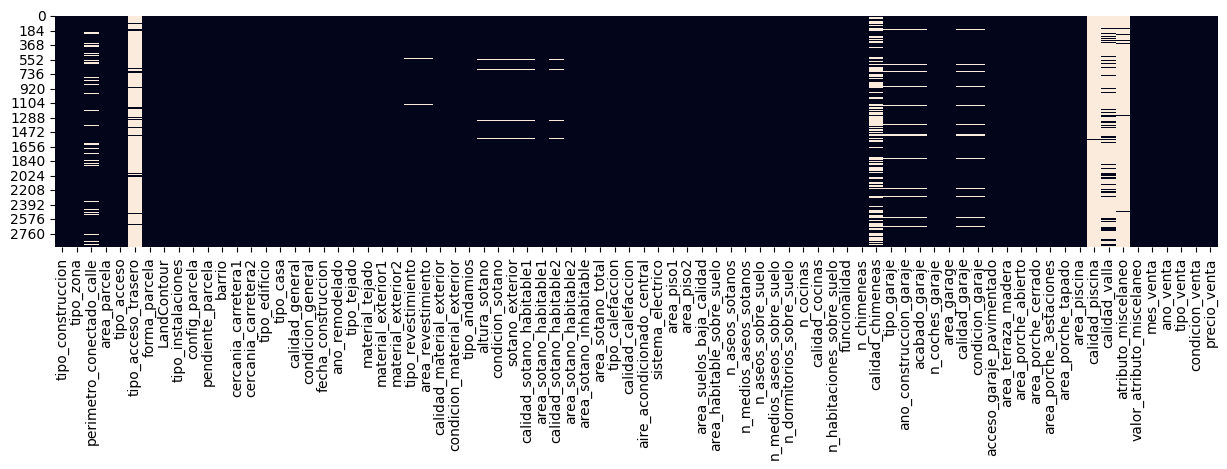

In [47]:
plt.figure(figsize=(15, 3))
sns.heatmap(df.isnull(), cbar=False)

In [48]:
df.shape

(2930, 80)

In [24]:
def del_null_column(dataframe, percentage ):
    column_null = dataframe.isnull().sum().reset_index()
    column_null.columns = ['Variable', 'Cantidad']
    column_null = column_null.sort_values('Cantidad', ascending=False)
    column_null = column_null[column_null['Cantidad'] > (len(dataframe)*percentage)]
    column_null = column_null['Variable'].tolist()
    dataframe.drop(column_null, axis = 1, inplace = True)
    
    print("Columnas eliminadas: ", column_null, "\nNueva Dimension del DataFrame: ", dataframe.shape) 


In [49]:
del_null_column(df, 0.3)

Columnas eliminadas:  ['calidad_piscina', 'atributo_miscelaneo', 'tipo_acceso_trasero', 'calidad_valla', 'calidad_chimeneas'] 
Nueva Dimension del DataFrame:  (2930, 75)


In [50]:
def del_null_row(dataframe, percentage ):
    column_null = dataframe.isnull().sum().reset_index()
    column_null.columns = ['Variable', 'Cantidad']
    column_null = column_null.sort_values('Cantidad', ascending=False)
    column_null = column_null[column_null['Cantidad'] > (len(dataframe)*percentage)]
    column_null = column_null['Variable'].tolist()
    dataframe.dropna(subset=column_null, inplace=True)
    
    print("Columnas con filas eliminadas: ", column_null, "\nNueva Dimension del DataFrame: ", dataframe.shape) 

In [51]:
del_null_row(df, 0.15)

Columnas con filas eliminadas:  ['perimetro_conectado_calle'] 
Nueva Dimension del DataFrame:  (2440, 75)


<Axes: >

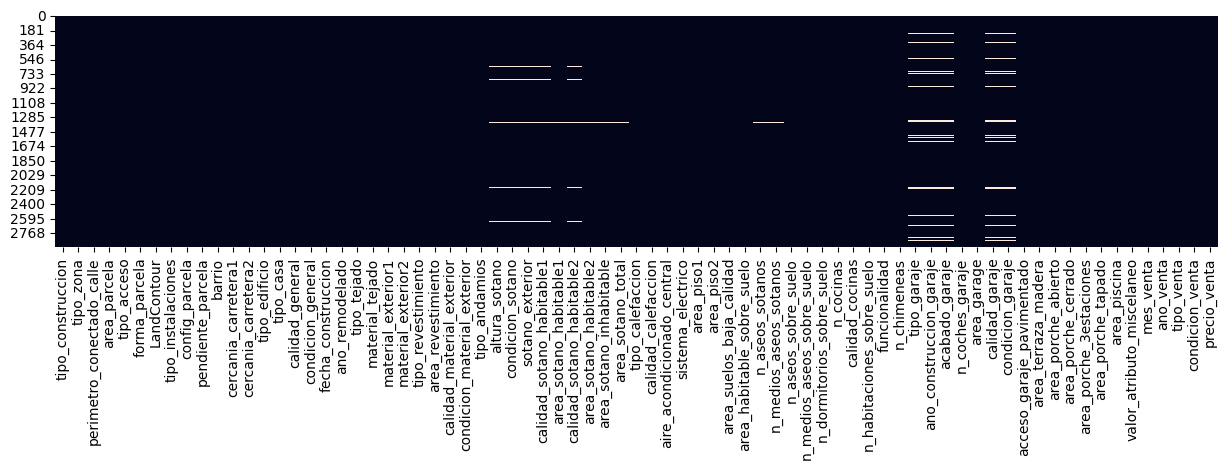

In [52]:
plt.figure(figsize=(15, 3))
sns.heatmap(df.isnull(), cbar=False)
# null_counts = df.isnull().sum().sort_values(ascending=False)
# null_counts.head(25)

## Division de Train y Test

In [53]:
# Separamos cabeceras
col_X = df.drop("precio_venta", axis=1).columns # X
col_y = ["precio_venta"] # y

# Separamos datos
X = df.drop(['precio_venta'], axis=1)     #variables_independientes
y = df['precio_venta']                   #variable_objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)        # stratify=y para variables objetivo para clasificacion o binarias

## Separacion entre datos numericos y categoricos

In [54]:
def numeric_split(dataframe, columns):
    numeric_data = dataframe[columns].select_dtypes([int, float])   
    return numeric_data

def categoric_split(dataframe, columns):
    categoric_data = dataframe[columns].select_dtypes([object])  
    return categoric_data

In [55]:
df_numeric_train = numeric_split(X_train, col_X)
df_numeric_train.shape

(1830, 35)

In [56]:
df_numeric_test = numeric_split(X_test, col_X)
df_numeric_test.shape

(610, 35)

In [57]:
df_categoric_train = categoric_split(X_train, col_X)
df_categoric_train.shape

(1830, 39)

In [58]:
df_categoric_test = categoric_split(X_test, col_X)
df_categoric_test.shape

(610, 39)

In [59]:
# Validacion

[col for col in df.columns if col not in df_numeric_train.columns and\
 col not in df_categoric_test.columns]

['precio_venta']

## Tratamiento datos nulos de Train y Test

In [60]:
def null_columns(dataframe):
    column_null = dataframe.isnull().sum().reset_index()
    column_null.columns = ['Variable', 'Cantidad']
    column_null = column_null.sort_values('Cantidad', ascending=False)
    column_null = column_null[column_null['Cantidad'] > 0]
    column_null = column_null['Variable'].tolist()
    
    return column_null

In [61]:
# Imputacion para datos numericos
# Si la distribucion es sesgada, llenar con la mediana
imputer_num = SimpleImputer(strategy='mean')

df_numeric_train_p = imputer_num.fit_transform(df_numeric_train)
df_numeric_test_p = imputer_num.transform(df_numeric_test)

df_numeric_train = pd.DataFrame(df_numeric_train_p, columns=df_numeric_train.columns)
df_numeric_test = pd.DataFrame(df_numeric_test_p, columns=df_numeric_test.columns)

In [62]:
# Para variables categoricas, reemplazaremos con el valor mas frecuente de cada columna
imputer_cat = SimpleImputer(strategy='most_frequent')

df_categoric_train_p = imputer_cat.fit_transform(df_categoric_train)
df_categoric_test_p = imputer_cat.transform(df_categoric_test)

df_categoric_train = pd.DataFrame(df_categoric_train_p, columns=df_categoric_train.columns)
df_categoric_test = pd.DataFrame(df_categoric_test_p, columns=df_categoric_test.columns)

## Tratamiento de Outliers

In [63]:
df_numeric_train_subset = df_numeric_train
df_numeric_test_subset = df_numeric_test

iso_forest = IsolationForest(max_samples='auto', contamination='auto', bootstrap=True, random_state=seed)       # muestra aleatoria con reemplaco
iso_forest.fit(df_numeric_train)

anomaly_labels = iso_forest.predict(df_numeric_train)
df_numeric_train_subset['Anomaly'] = anomaly_labels
df_numeric_train = df_numeric_train_subset[df_numeric_train_subset['Anomaly'] != -1].copy()
df_numeric_train.drop('Anomaly', axis = 1, inplace=True)

anomaly_labels = iso_forest.predict(df_numeric_test)
df_numeric_test_subset['Anomaly'] = anomaly_labels
df_numeric_test = df_numeric_test_subset[df_numeric_test_subset['Anomaly'] != -1].copy()
df_numeric_test.drop('Anomaly', axis = 1, inplace=True)

In [64]:
df_numeric_train.shape

(1738, 35)

In [65]:
df_numeric_test.shape

(577, 35)

In [66]:
# igualamos con los datos categoricos
df_categoric_train = df_categoric_train.loc[df_numeric_train.index]
df_categoric_train.shape

(1738, 39)

In [67]:
df_categoric_test = df_categoric_test.loc[df_numeric_test.index]
df_categoric_test.shape

(577, 39)

## Procesado de datos Categoricos

Iniciamos con los datos ordinales realizando one hot encoding

In [68]:
# para crear este diccionario he ido a la descripcion del dataset
dict_var_ordinal = {
    "calidad_cocinas": ["Po", "Fa", "TA", "Gd", "Ex"],
    "funcionalidad":["Sal", "Sev", "Maj2", "Maj1", "Min2", "Min1","Typ"],
    #"calidad_chimeneas":["NA","Po","Fa","TA","Gd","Ex"],
    "acabado_garaje":["NA","Unf","RFn","Fin"],
    "calidad_garaje":["NA","Po","Fa","TA","Gd","Ex"],
    "condicion_garaje":["NA","Po","Fa","TA","Gd","Ex"],
    "acceso_garaje_pavimentado":["N", "P", "Y"],
    #"calidad_piscina":["NA","Fa","TA","Gd","Ex"],
    #"calidad_valla":["NA","MnWw","GdWo","MnPrv","GdPrv"],
    "forma_parcela":["IR3", "IR2", "IR1","Reg"],
    "tipo_instalaciones":["ELO","NoSeWa","NoSewr","AllPub"],
    "pendiente_parcela":["Sev", "Mod", "Gtl"],
    "calidad_material_exterior":["Po","Fa","TA","Gd","Ex"],
    "condicion_material_exterior":["Po","Fa","TA","Gd","Ex"],
    "altura_sotano":["NA","Po","Fa","TA","Gd","Ex"],
    "condicion_sotano":["NA","Po","Fa","TA","Gd","Ex"],
    "sotano_exterior":["NA","No","Mn","Av","Gd"],
    "calidad_sotano_habitable1":["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "calidad_sotano_habitable2":["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
     "calidad_calefaccion":["Po","Fa","TA","Gd","Ex"],
}

In [70]:
def pro_ordinal (diccionario, dataframe):
    col_ordinal = list(diccionario.keys())
    ordinal_data = dataframe[col_ordinal]

    for ordinal_column, values in dict_var_ordinal.items():
        ordinal_data[ordinal_column] = (
        ordinal_data[ordinal_column]
        .astype("category")
        .cat.set_categories(values)
        .cat.codes
    )
    
    return ordinal_data    

In [71]:
ordinal_data_train = pro_ordinal(dict_var_ordinal, df_categoric_train)
ordinal_data_train.shape

(1738, 17)

In [72]:
ordinal_data_test = pro_ordinal(dict_var_ordinal, df_categoric_test)
ordinal_data_test.shape

(577, 17)

Continuamos con las variables nominales realizando get dummies

In [73]:
def nominal_categoric_train (df_categoric, df_ordinal):
    nominal_column = list(set(df_categoric.columns) - set(df_ordinal.columns))
    nominal_data = df_categoric[nominal_column]
    nominal_data = pd.get_dummies(nominal_data)
    
    return nominal_data

def nominal_categoric_test (df_categoric, df_ordinal, df_nominal_train):
    nominal_column = list(set(df_categoric.columns) - set(df_ordinal.columns))
    nominal_data = df_categoric[nominal_column]
    nominal_data = pd.get_dummies(nominal_data)
    
    missing_cols = set( df_nominal_train.columns ) - set( nominal_data.columns )
    for c in missing_cols:
        nominal_data[c] = 0
    nominal_data = nominal_data[df_nominal_train.columns]
    
    return nominal_data

In [90]:
nominal_data_train = nominal_categoric_train(df_categoric_train, ordinal_data_train)
nominal_data_train.shape

(1738, 256)

In [75]:
nominal_data_test = nominal_categoric_test(df_categoric_test, ordinal_data_test, nominal_data_train)
nominal_data_test.shape

(577, 256)

In [110]:
# enc_nominal = OneHotEncoder()

# nominal_column = list(set(df_categoric_train.columns) - set(ordinal_data_train.columns))

# nominal_data_train_OneH = df_categoric_train[nominal_column]
# nominal_data_test_OneH = df_categoric_test[nominal_column]

# nominal_data_train_OneH = enc_nominal.fit_transform(nominal_data_train_OneH)
# nominal_data_test_OneH = enc_nominal.transform(nominal_data_test_OneH)

## Procesado de datos Numericos

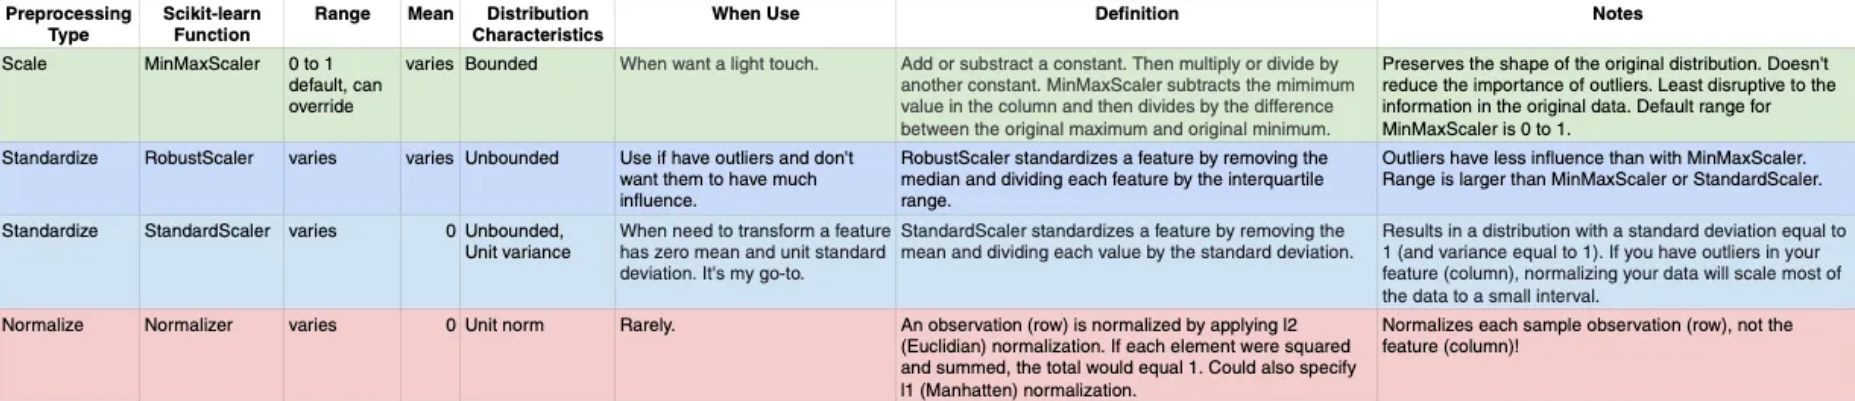

In [61]:
# https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
from IPython.display import Image
Image("scale.png")

In [76]:
minmax = MinMaxScaler()

X_train_minmax = minmax.fit_transform(df_numeric_train)
X_test_minmax = minmax.transform(df_numeric_test)

df_numeric_train_minmax = pd.DataFrame(X_train_minmax, columns=df_numeric_train.columns)
df_numeric_test_minmax = pd.DataFrame(X_test_minmax, columns=df_numeric_test.columns)

In [77]:
df_numeric_train_minmax.shape

(1738, 35)

In [78]:
df_numeric_test_minmax.shape

(577, 35)

In [79]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(df_numeric_train)
X_test_scaler = scaler.transform(df_numeric_test)

df_numeric_train_scaler = pd.DataFrame(X_train_scaler, columns=df_numeric_train.columns)
df_numeric_test_scaler = pd.DataFrame(X_test_scaler, columns=df_numeric_test.columns)

In [80]:
df_numeric_train_scaler.shape

(1738, 35)

In [81]:
df_numeric_test_scaler.shape

(577, 35)

## Unimos los datos procesados

In [82]:
def union_dataframe(df_numeric, df_ordinal, df_nominal):
    df_1 = df_numeric.reset_index(drop=True)
    df_2 = df_ordinal.reset_index(drop=True)
    df_3 = df_nominal.reset_index(drop=True)
    
    df_final = pd.concat([df_1, df_2, df_3], axis=1)

    return df_final

In [83]:
df_X_train = union_dataframe(df_numeric_train_scaler, ordinal_data_train, nominal_data_train)
df_X_train.shape

(1738, 308)

In [84]:
df_X_test = union_dataframe(df_numeric_test_scaler, ordinal_data_test, nominal_data_test)
df_X_test.shape

(577, 308)

In [85]:
df_X_train.head()

,tipo_construccion,perimetro_conectado_calle,area_parcela,calidad_general,condicion_general,fecha_construccion,ano_remodelado,area_revestimiento,area_sotano_habitable1,area_sotano_habitable2,...,cercania_carretera1_RRNe,cercania_carretera1_RRNn,tipo_casa_1.5Fin,tipo_casa_1.5Unf,tipo_casa_1Story,tipo_casa_2.5Fin,tipo_casa_2.5Unf,tipo_casa_2Story,tipo_casa_SFoyer,tipo_casa_SLvl
0,0.063544,1.154544,0.911535,0.676800,1.358750,0.270674,-0.213296,1.105501,0.645369,-0.281337,...,0,0,0,0,0,0,0,1,0,0
1,-0.853919,1.787584,0.952537,2.116552,-0.541095,1.117360,1.052719,1.238195,2.711127,-0.281337,...,0,0,0,0,1,0,0,0,0,0
2,-0.624554,-0.382836,0.373382,-0.762953,1.358750,-1.683216,-1.619979,-0.571275,-0.979067,-0.281337,...,0,0,0,0,1,0,0,0,0,0
3,-0.280505,-0.428053,-0.498647,-0.043077,0.408827,-0.576011,-1.432421,-0.571275,-0.979067,-0.281337,...,0,0,0,1,0,0,0,0,0,0
4,-0.853919,1.380630,0.629889,0.676800,-0.541095,0.596322,0.255599,-0.571275,-0.979067,-0.281337,...,0,0,0,0,1,0,0,0,0,0


In [86]:
df_X_test.head()

,tipo_construccion,perimetro_conectado_calle,area_parcela,calidad_general,condicion_general,fecha_construccion,ano_remodelado,area_revestimiento,area_sotano_habitable1,area_sotano_habitable2,...,cercania_carretera1_RRNe,cercania_carretera1_RRNn,tipo_casa_1.5Fin,tipo_casa_1.5Unf,tipo_casa_1Story,tipo_casa_2.5Fin,tipo_casa_2.5Unf,tipo_casa_2Story,tipo_casa_SFoyer,tipo_casa_SLvl
0,-0.853919,0.973676,0.663325,-0.043077,0.408827,-0.478317,-1.291753,-0.571275,0.844903,-0.281337,...,0,0,0,0,1,0,0,0,0,0
1,0.292910,2.330189,1.087991,-0.043077,1.358750,-1.194743,0.068041,-0.571275,0.490437,-0.281337,...,0,0,0,0,0,0,0,1,0,0
2,-0.624554,-0.382836,-0.944545,-0.762953,0.408827,-1.650651,-0.775969,-0.571275,-0.979067,-0.281337,...,0,0,0,0,1,0,0,0,0,0
3,-0.853919,0.476288,0.035602,0.676800,-0.541095,1.149924,1.052719,0.665196,1.664163,-0.281337,...,0,0,0,0,1,0,0,0,0,0
4,-0.165822,0.521505,1.915844,-1.482829,-1.491018,-0.413187,-1.197974,-0.571275,-0.979067,-0.281337,...,0,0,1,0,0,0,0,0,0,0
